# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import prince
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from scipy.stats import chi2_contingency, rankdata
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# load data
df = pd.read_csv('data_for_models_project1.csv')

In [3]:
# divide data into train and test
X = df.drop('Y', axis=1)
#y = df['Y']
# load txt file as y 
y = np.loadtxt('y_pred_k_medoids_2.txt')


# Classification with variance/bias tradeoff methods

### Preprocessing and model identification

In [4]:
# Define model configurations
model_configs = [
    {
        'name': 'Random Forest',
        'classifier': RandomForestClassifier(n_estimators=500, max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, random_state=42)
    },
    {
        'name': 'XGBoost',
        'classifier': XGBClassifier(
            n_estimators=1000,
            max_depth=15,
            learning_rate=0.01,
            subsample=0.5,
            colsample_bytree=0.5,
            gamma=0.1,
            random_state=42
        )
    },
]

### Holdout


Training Size: 10088, Test Size: 2522
----------------------------------------
Running Random Forest...


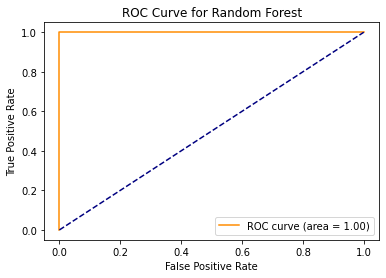

Random Forest F1 Score: 1.0000


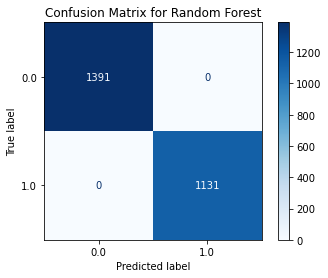

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1391
         1.0       1.00      1.00      1.00      1131

    accuracy                           1.00      2522
   macro avg       1.00      1.00      1.00      2522
weighted avg       1.00      1.00      1.00      2522

------------------------------------------------------------
Running XGBoost...


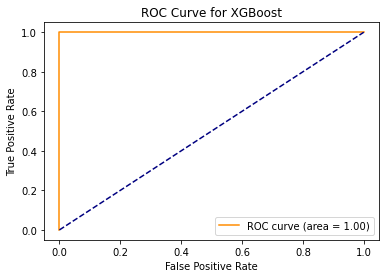

XGBoost F1 Score: 1.0000


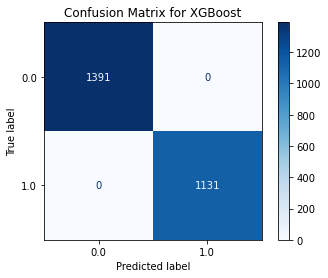

XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1391
         1.0       1.00      1.00      1.00      1131

    accuracy                           1.00      2522
   macro avg       1.00      1.00      1.00      2522
weighted avg       1.00      1.00      1.00      2522

------------------------------------------------------------

Training Size: 9457, Test Size: 3153
----------------------------------------
Running Random Forest...


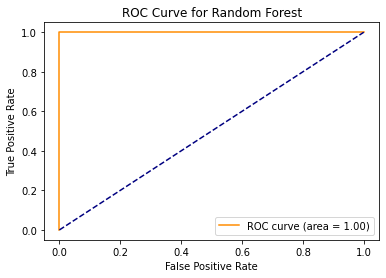

Random Forest F1 Score: 1.0000


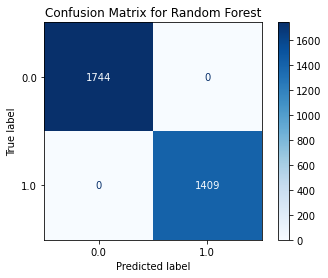

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1744
         1.0       1.00      1.00      1.00      1409

    accuracy                           1.00      3153
   macro avg       1.00      1.00      1.00      3153
weighted avg       1.00      1.00      1.00      3153

------------------------------------------------------------
Running XGBoost...


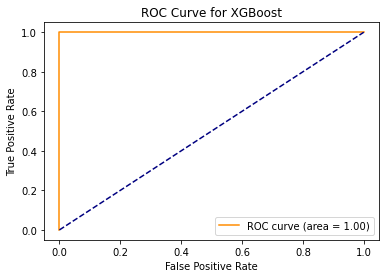

XGBoost F1 Score: 1.0000


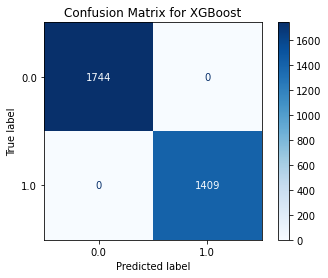

XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1744
         1.0       1.00      1.00      1.00      1409

    accuracy                           1.00      3153
   macro avg       1.00      1.00      1.00      3153
weighted avg       1.00      1.00      1.00      3153

------------------------------------------------------------

Training Size: 8827, Test Size: 3783
----------------------------------------
Running Random Forest...


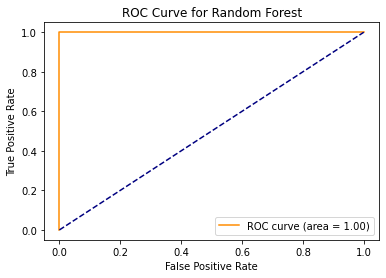

Random Forest F1 Score: 1.0000


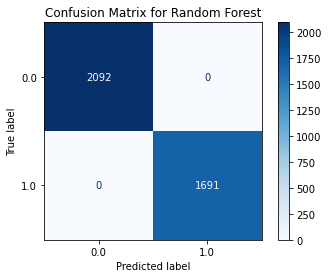

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2092
         1.0       1.00      1.00      1.00      1691

    accuracy                           1.00      3783
   macro avg       1.00      1.00      1.00      3783
weighted avg       1.00      1.00      1.00      3783

------------------------------------------------------------
Running XGBoost...


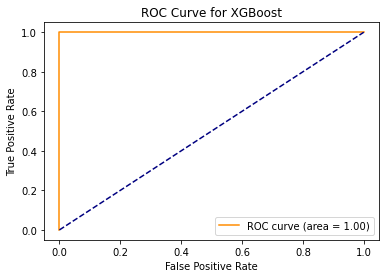

XGBoost F1 Score: 1.0000


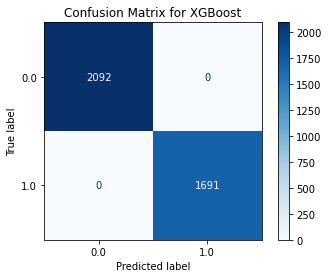

XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2092
         1.0       1.00      1.00      1.00      1691

    accuracy                           1.00      3783
   macro avg       1.00      1.00      1.00      3783
weighted avg       1.00      1.00      1.00      3783

------------------------------------------------------------


In [5]:
# Define a function to split data with multiple test sizes
def split_data_for_multiple_test_sizes(X, y, test_sizes):
    data_splits = []
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        data_splits.append((X_train, X_test, y_train, y_test))
    return data_splits

test_sizes = [0.2, 0.25, 0.3]  # This corresponds to 80%, 75%, and 70% training sizes
data_splits = split_data_for_multiple_test_sizes(X, y, test_sizes)

# Loop through the splits
for data in data_splits:
    X_train, X_test, y_train, y_test = data
    print(f"\nTraining Size: {len(X_train)}, Test Size: {len(X_test)}\n{'-'*40}")
    
    # Updated loop for models to include categorical columns
    for model_config in model_configs:
        print(f"Running {model_config['name']}...")
        
        X_train_processed = X_train
        X_test_processed = X_test

        X_train_processed = np.ascontiguousarray(X_train_processed)
        X_test_processed = np.ascontiguousarray(X_test_processed)

        model_config['classifier'].fit(X_train_processed, y_train)
    
        y_pred = model_config['classifier'].predict(X_test_processed)

        # ROC curve and AUC
        if len(set(y_test)) == 2:  # Ensure binary classification
            y_prob = model_config['classifier'].predict_proba(X_test_processed)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {model_config["name"]}')
            plt.legend(loc="lower right")
            plt.show()

        # F1 score
        f1 = f1_score(y_test, y_pred)
        print(f"{model_config['name']} F1 Score: {f1:.4f}")

        # Compute the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot the confusion matrix using ConfusionMatrixDisplay
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_test))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_config["name"]}')
        plt.show()
        
        print(f"{model_config['name']} Classification Report:")
        print(classification_report(y_test, y_pred))
        print('-' * 60)

### Bootstrapping

Iteration 1/10
Running Random Forest...


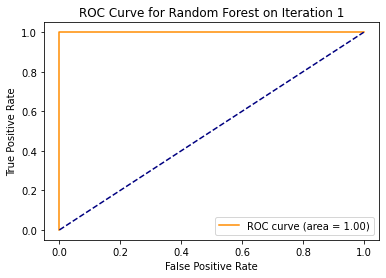

Random Forest F1 Score for Iteration 1: 1.0000


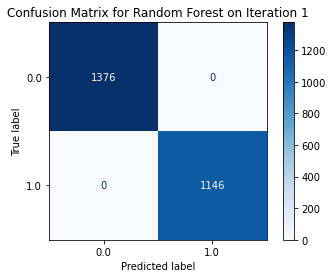

Running XGBoost...


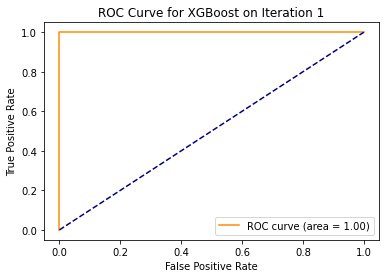

XGBoost F1 Score for Iteration 1: 1.0000


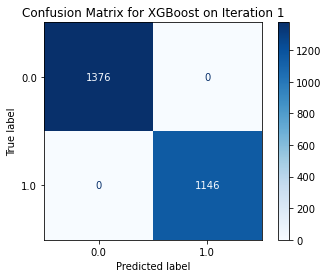

Iteration 2/10
Running Random Forest...


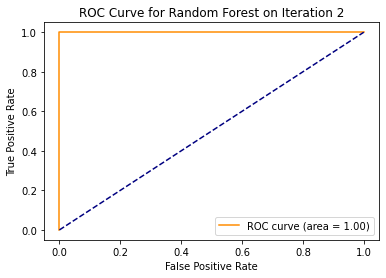

Random Forest F1 Score for Iteration 2: 1.0000


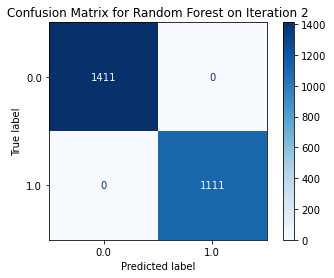

Running XGBoost...


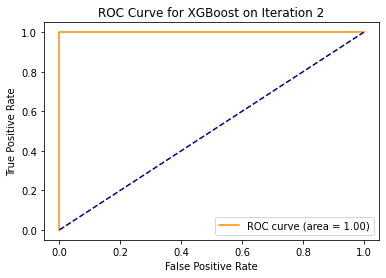

XGBoost F1 Score for Iteration 2: 1.0000


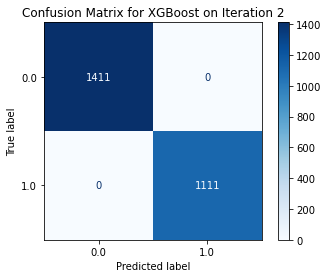

Iteration 3/10
Running Random Forest...


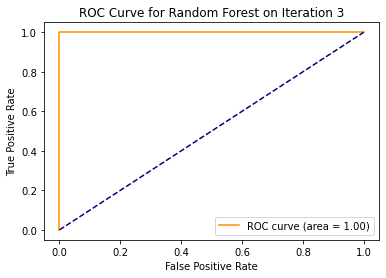

Random Forest F1 Score for Iteration 3: 1.0000


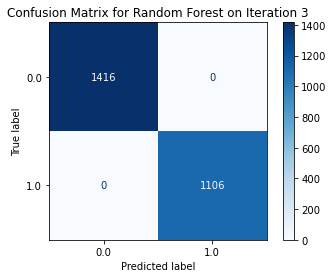

Running XGBoost...


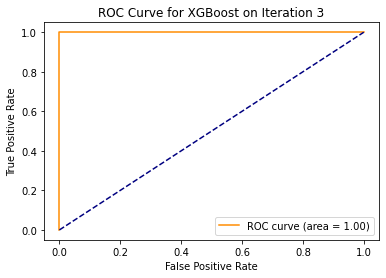

XGBoost F1 Score for Iteration 3: 1.0000


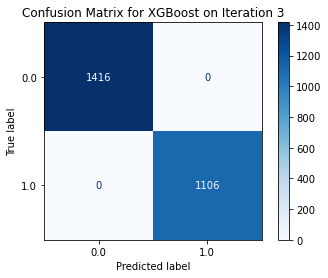

Iteration 4/10
Running Random Forest...


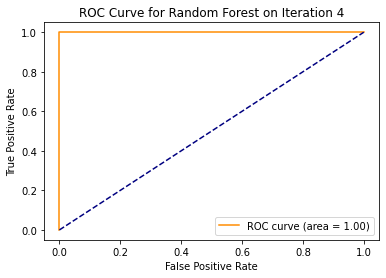

Random Forest F1 Score for Iteration 4: 1.0000


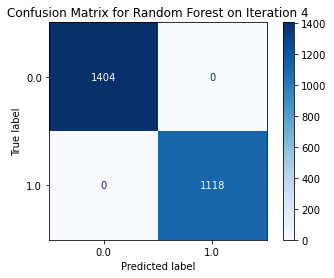

Running XGBoost...


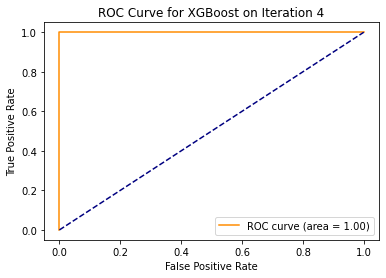

XGBoost F1 Score for Iteration 4: 1.0000


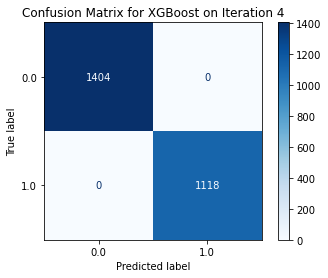

Iteration 5/10
Running Random Forest...


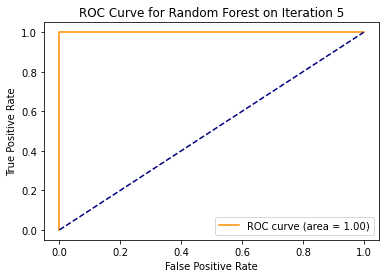

Random Forest F1 Score for Iteration 5: 1.0000


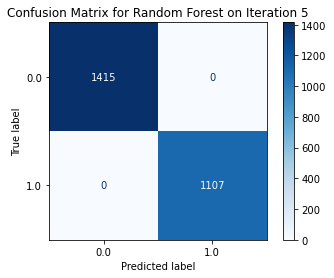

Running XGBoost...


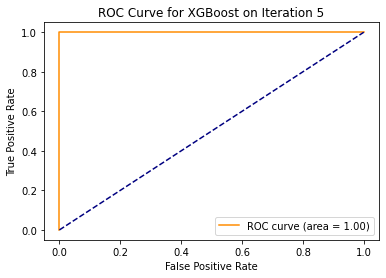

XGBoost F1 Score for Iteration 5: 1.0000


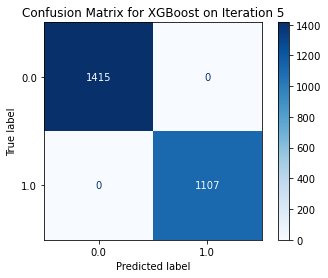

Iteration 6/10
Running Random Forest...


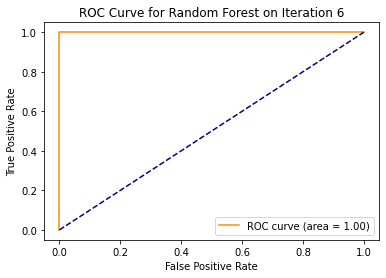

Random Forest F1 Score for Iteration 6: 1.0000


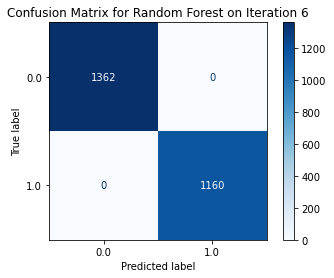

Running XGBoost...


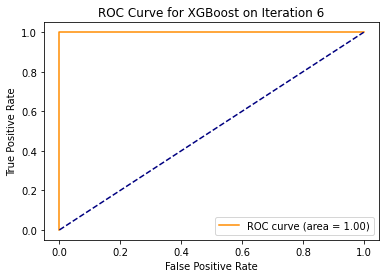

XGBoost F1 Score for Iteration 6: 1.0000


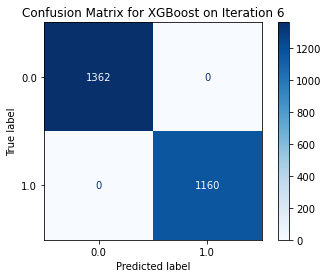

Iteration 7/10
Running Random Forest...


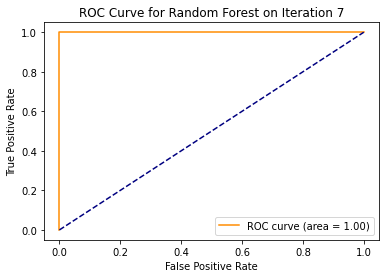

Random Forest F1 Score for Iteration 7: 1.0000


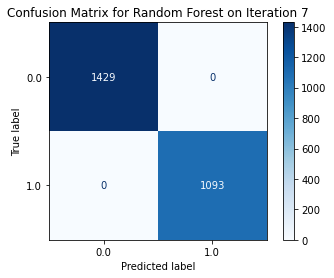

Running XGBoost...


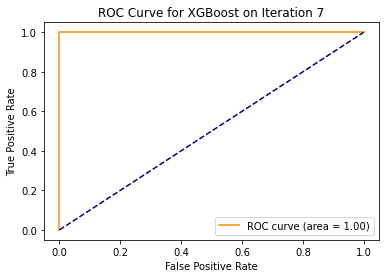

XGBoost F1 Score for Iteration 7: 1.0000


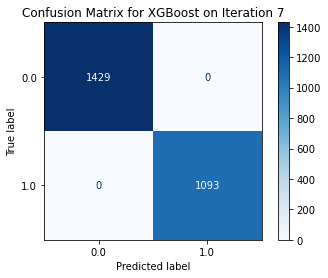

Iteration 8/10
Running Random Forest...


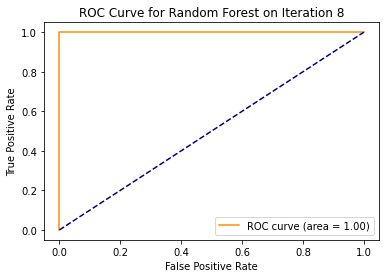

Random Forest F1 Score for Iteration 8: 1.0000


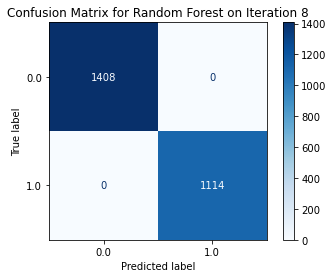

Running XGBoost...


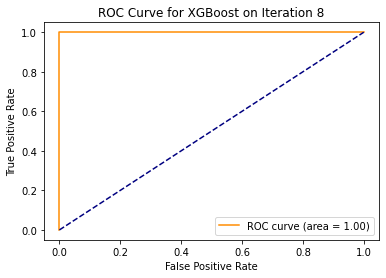

XGBoost F1 Score for Iteration 8: 1.0000


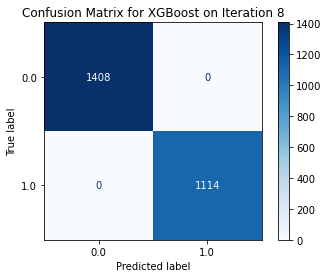

Iteration 9/10
Running Random Forest...


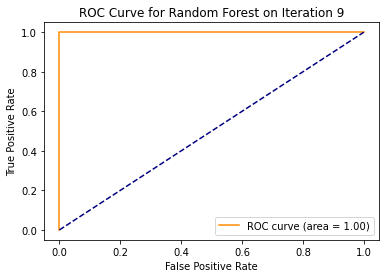

Random Forest F1 Score for Iteration 9: 1.0000


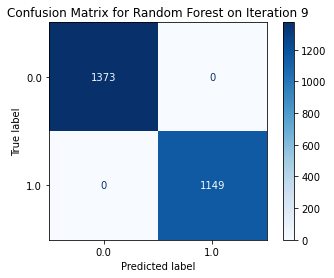

Running XGBoost...


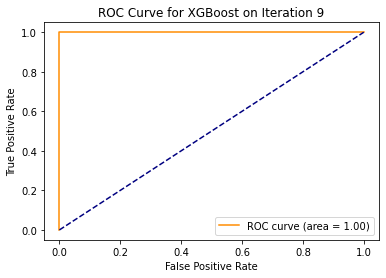

XGBoost F1 Score for Iteration 9: 1.0000


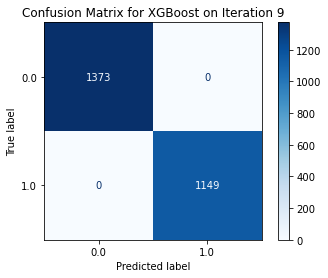

Iteration 10/10
Running Random Forest...


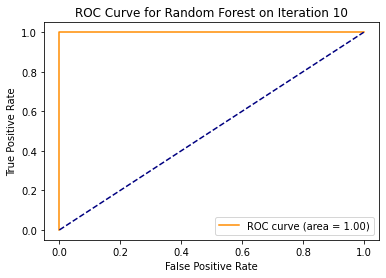

Random Forest F1 Score for Iteration 10: 1.0000


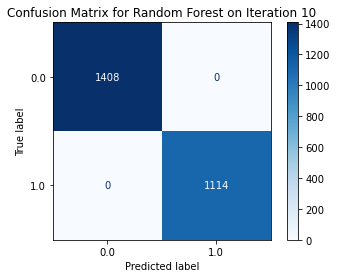

Running XGBoost...


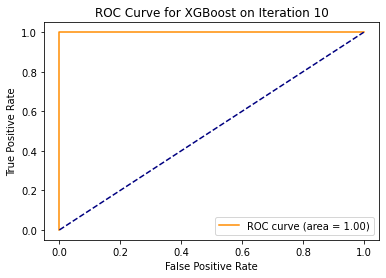

XGBoost F1 Score for Iteration 10: 1.0000


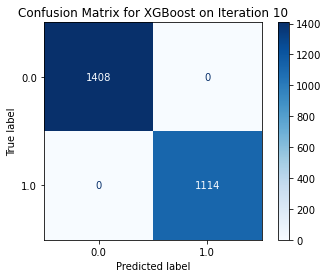

In [7]:
from sklearn.utils import resample

def bootstrap_evaluation(models, X, y, n_iterations=1000, sample_size=None):
    """
    Perform bootstrap evaluation for given models on data X, y.
    
    models: list of dictionaries, where each dictionary has 'name', 'preprocess', and 'classifier'
    X: Feature matrix
    y: Target vector
    n_iterations: Number of bootstrap iterations
    sample_size: Size of each bootstrap sample, if None, set to len(y)
    
    Returns: model scores for each iteration
    """
    if sample_size is None:
        sample_size = len(y)

    # Store scores for each model and iteration
    model_scores = {model['name']: [] for model in models}

    for i in range(n_iterations):
        print(f"Iteration {i+1}/{n_iterations}")
        # Sample data with replacement
        X_sample, y_sample = resample(X, y, n_samples=sample_size, replace=True)

        # Split into train and test sets (e.g., 80/20 split)
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=i)

        # Process, train, and evaluate each model
        for config in models:
            print(f"Running {config['name']}...")
            
            X_train_pp = X_train 
            X_test_pp = X_test

            X_train_pp = np.ascontiguousarray(X_train_pp)
            X_test_pp = np.ascontiguousarray(X_test_pp)

            
            clf = config['classifier']
            clf.fit(X_train_pp, y_train)
            y_pred = clf.predict(X_test_pp)
    
            # ROC curve and AUC
            if len(set(y_test)) == 2:  # Ensure binary classification
                y_prob = clf.predict_proba(X_test_pp)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)

                plt.figure()
                plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve for {config["name"]} on Iteration {i+1}')
                plt.legend(loc="lower right")
                plt.show()

            # F1 score
            f1 = f1_score(y_test, y_pred)
            print(f"{config['name']} F1 Score for Iteration {i+1}: {f1:.4f}")

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_test))
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix for {config["name"]} on Iteration {i+1}')
            plt.show()

            # Accuracy for the iteration
            score = accuracy_score(y_test, y_pred)
            model_scores[config['name']].append(score)

    return model_scores

# Use the same `model_configs` list from the previous K-fold CV example
bootstrap_scores = bootstrap_evaluation(model_configs, X, y, n_iterations=10)
# Maybe we need do run this for 50-100 times for stability

### Boostrapping results

c:\Users\leo_b\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
c:\Users\leo_b\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


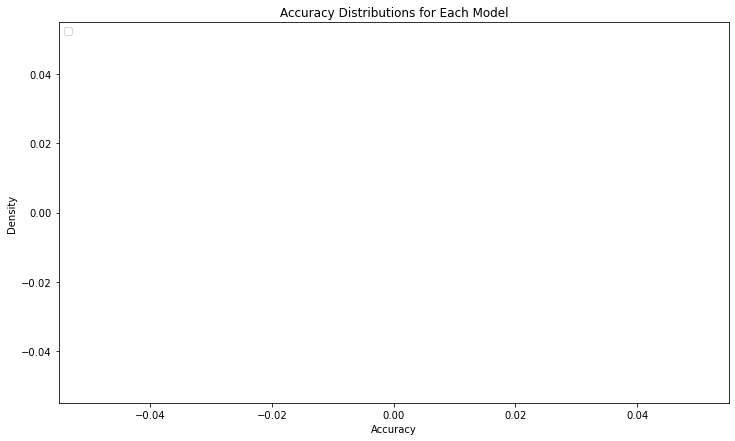

In [9]:
# Plot the scores, as distributions (not with distplot, it is deprecated), with the legend on the top left corner
plt.figure(figsize=(12, 7))
for model_name, scores in bootstrap_scores.items():
    sns.kdeplot(scores, label=model_name, fill=True)
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Accuracy Distributions for Each Model')
plt.legend(loc='upper left', bbox_to_anchor=(.0, 1))
plt.show()